## Github Dataset

In [ ]:
!git clone https://github.com/Shujun-Wu-98/Catheter-and-Line.git

Cloning into 'Catheter-and-Line'...
remote: Enumerating objects: 35712, done.
remote: Counting objects: 100% (1255/1255), done.
remote: Compressing objects: 100% (1211/1211), done.
remote: Total 35712 (delta 45), reused 1254 (delta 44), pack-reused 34457
Receiving objects: 100% (35712/35712), 6.70 GiB | 29.60 MiB/s, done.
Resolving deltas: 100% (1279/1279), done.
Checking out files: 100% (33668/33668), done.


In [ ]:
!pip install -U git+https://github.com/albu/albumentations
!pip install timm
!pip install opencv-python

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-k2gi62s2
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-k2gi62s2
  Created wheel for albumentations: filename=albumentations-1.0.3-py3-none-any.whl size=98755 sha256=5c3c862cf7b038dd342544ce6a9cb6820308d2808ed4435059f3632c6be41db2
  Stored in directory: /tmp/pip-ephem-wheel-cache-zdkdxe90/wheels/63/11/1a/c77caf3ae9b9b6d57b3ee5e6a41a50f3bc12c66a70f6b90bf0
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 376 kB 12.9 MB/s 


## Import Packages

In [ ]:
#import the libraries
import numpy as np
import cv2
from PIL import Image
import time
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
torch.set_printoptions(precision=6,sci_mode=False)
import matplotlib.pyplot as plt
%matplotlib inline
import albumentations
from albumentations import *
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
import timm
from sklearn.metrics import explained_variance_score,roc_auc_score, confusion_matrix


import seaborn as sns

## Check the GPU

In [ ]:
#device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Jul 27 01:59:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Config file

In [ ]:
#data path

TRAIN_IMAGE_DIR = '/content/Catheter-and-Line/train/'
TEST_IMAGE_DIR = '/content/Catheter-and-Line/test/'
TRAIN_CSV = '/content/Catheter-and-Line/train.csv'

#read submission csv file
sub_dir = '/content/Catheter-and-Line/sample_submission.csv'

#something useful parameters in this project
#batch_size设置为8，因为大了的话无法运行，报错out of memory
BATCH_SIZE = 8
IMAGE_SIZE = 512

#read csv by pandas package
df_train = pd.read_csv(TRAIN_CSV)

#Pack all column names as labels
LABELS = [
            'ETT - Abnormal',
            'ETT - Borderline',
            'ETT - Normal',
            'NGT - Abnormal',
            'NGT - Borderline',
            'NGT - Incompletely Imaged',
            'NGT - Normal',
            'CVC - Abnormal',
            'CVC - Borderline',
            'CVC - Normal',
            'Swan Ganz Catheter Present'
]

df_train.head()


,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1


In [ ]:

#set the debug data which can save time when we meet some errors
DEBUG = False
if DEBUG:
  df_train = df_train.sample(frac=0.1).reset_index(drop=True)
  print(df_train.shape)

#split the train data to training dataset and validation dataset
train_set, valid_set = train_test_split(df_train, test_size = 0.2) #这只是分为了训练和测试集，并不是交叉验证集
print(train_set.shape, valid_set.shape)

(24066, 13) (6017, 13)


## Dataset

In [ ]:
#load dataset
class Ranzcr_Images(Dataset):

    def __init__(self, df, transform=None):
        
        self.df = df
        self.image_ids = df["StudyInstanceUID"].values
        self.labels = df[LABELS].values
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):
        """ Returns image,labels. """

        image_id = self.image_ids[index]
        path = TRAIN_IMAGE_DIR + str(image_id) + ".jpg"
        image = cv2.imread(path,0)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            res = self.transform(image=image)
            img = res['image']

        label = torch.tensor(self.labels[index]).float()

        return img, label


## Model

In [ ]:
#define model
class RanzcrNet(nn.Module):
  def __init__(self, model_name='resnet200d', out_dim = 11):
    super().__init__()
    self.model = timm.create_model(model_name, pretrained=True)
    n_features = self.model.fc.in_features
    self.model.global_pool = nn.Identity()
    self.model.fc = nn.Identity()
    self.pooling = nn.AdaptiveAvgPool2d(1)
    self.fc = nn.Linear(n_features, out_dim)


  def forward(self, x):
    bs = x.size(0)
    features = self.model(x)
    pooled_features = self.pooling(features).view(bs,-1)
    output = self.fc(pooled_features)
    
    return output


## Transforms

In [ ]:
transforms_train = albumentations.Compose([
   
   albumentations.RandomResizedCrop(IMAGE_SIZE, IMAGE_SIZE, scale=(0.9, 1), p=1), 
   albumentations.HorizontalFlip(p=0.5),
   albumentations.ShiftScaleRotate(p=0.5),

   albumentations.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.7),
   albumentations.RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2), p=0.7),
   albumentations.CLAHE(clip_limit=(1,4), p=0.9),
   albumentations.ColorJitter (brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
   
   albumentations.OneOf([
       albumentations.OpticalDistortion(distort_limit=1.0),
       albumentations.GridDistortion(num_steps=5, distort_limit=1.),
       albumentations.ElasticTransform(alpha=3),
   ], p=0.2),

   albumentations.OneOf([
       albumentations.GaussNoise(var_limit=[10, 50]),
       albumentations.GaussianBlur(),
       albumentations.MotionBlur(),
       albumentations.MedianBlur(),
   ], p=0.2),

   albumentations.Resize(IMAGE_SIZE, IMAGE_SIZE),
   
   albumentations.OneOf([
       ImageCompression(),
       Downscale(scale_min=0.1, scale_max=0.15),
   ], p=0.2),
   PiecewiseAffine(p=0.2),
   Sharpen(p=0.2),
   albumentations.CoarseDropout(max_holes=5,max_height=int(IMAGE_SIZE * 0.1), max_width=int(IMAGE_SIZE * 0.1), p=0.5),
   Normalize(                    #using ImageNet norms
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225],
   ),
   ToTensorV2()
])

In [ ]:
transforms_test = albumentations.Compose([
    Resize(IMAGE_SIZE,IMAGE_SIZE),
    Normalize(                    #using ImageNet norms
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2()
])

## Dataset and DataLoader

In [ ]:
#build dataset
train_dataset = Ranzcr_Images(
    train_set, 
    transform=transforms_train,
    )
valid_dataset = Ranzcr_Images(
    valid_set, 
    transform=transforms_test,
    )

#build train dataloader
train_loader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2,
    pin_memory=True,
)

#build valid dataloader
valid_loader = DataLoader(
    valid_dataset,
    batch_size = 64,
    shuffle = False,
    num_workers = 2,
    pin_memory=True,
)


In [ ]:
#print the information of two dataset
print(len(train_dataset))
print(len(valid_dataset))

#print the information of two loader
print(len(train_loader))
print(len(valid_loader))

24066
6017
3009
95


## Utils

转换标签

In [ ]:
def fzto(pred):
  for i in range(len(pred)):
    for j in range(len(pred[i])):
      if pred[i][j]<0.5:
        pred[i][j]=0
      else:
        pred[i][j]=1
  return pred

计算准确度

In [ ]:

def macro_multilabel_auc(label, pred):
    aucs = []
    for i in range(len(LABELS)):
        aucs.append(roc_auc_score(label[:, i], pred[:, i]))
    return np.mean(aucs)

In [ ]:
def conf_matrix(label, pred,i):
      confusion = confusion_matrix(label[:,i],pred[:,i])

      plt.imshow(confusion, cmap=plt.cm.Blues)
      plt.rcParams['figure.figsize'] = (8.0, 8.0)
      indices = range(len(confusion))
      plt.xticks(indices, ['0','1'])
      plt.yticks(indices, ['0','1'])

      plt.colorbar()

      plt.xlabel('Predicted Labels')
      plt.ylabel('True Labels')
      plt.title(LABELS[i]+'Train Confusion Matrix')

      for first_index in range(len(confusion)):  
          for second_index in range(len(confusion[first_index])): 
              plt.text(first_index, second_index, confusion[first_index][second_index])
      plt.show()

## Training

#### Train the model and caculate the valid loss

In [ ]:
start = time.time()
#put model onto GPU
model = RanzcrNet()
if torch.cuda.device_count()>1:
  print(torch.cuda.device_count())
  model = nn.DataParallel(model)
model = model.to(device)


#loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.Adam(model.parameters(),lr=0.02)
optimizer = optim.SGD(model.parameters(),lr=0.1,momentum=0.9)

n = 25

#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min = 0.0005, verbose=1)

pic = np.zeros((2,n))

#start training the model in n epochs
for epoch in range(n):
  #scheduler.step(epoch)
  p = torch.zeros(1,11)
  l = torch.zeros(1,11)
  train_loss = 0
  model.train()
  for i,data in enumerate(train_loader):

    image, labels = data[0].to(device),data[1].to(device)

    optimizer.zero_grad()
    output = model(image)

    t_loss = criterion(output, labels)
    t_loss.backward()

    optimizer.step()

    train_loss += t_loss.item()

  #set the validation set loss
  valid_loss = 0
  model.eval()

  with torch.no_grad():
    for index,data in enumerate(valid_loader):
      
      image, labels = data[0].to(device),data[1].to(device)

      pred = model(image)
      
      pred_1 = pred.sigmoid().detach().cpu()
      pred_1 = fzto(pred_1)
      labels_1 = labels.cpu()
      p = torch.cat((p,pred_1),0)
      l = torch.cat((l,labels_1),0)
      
      v_loss = criterion(pred, labels)
      valid_loss += v_loss.item()

  _,p = torch.split(p,[1,len(valid_dataset)])
  _,l = torch.split(l,[1,len(valid_dataset)])
  
  print(macro_multilabel_auc(l, p))
  #print(explained_variance_score(l,p))
#  scheduler.step()#explained_variance_score(l,p))

  pic[:,epoch] = train_loss/len(train_loader),valid_loss/len(valid_loader)

  
  print(f"EPOCH:{epoch}, Train_Loss:{train_loss/len(train_loader): .6f},Valid_Loss:{valid_loss/len(valid_loader): .6f}")

end = time.time()
print('running time : %s min'%((end-start)/60))

0.6143055578727921
EPOCH:0, Train_Loss: 0.244358,Valid_Loss: 0.217905
0.6482641478281449
EPOCH:1, Train_Loss: 0.217067,Valid_Loss: 0.190333
0.6853238192537363
EPOCH:2, Train_Loss: 0.200165,Valid_Loss: 0.166591
0.7060859300044784
EPOCH:3, Train_Loss: 0.190436,Valid_Loss: 0.153031
0.7063145411351767
EPOCH:4, Train_Loss: 0.183947,Valid_Loss: 0.153064
0.7011883972157155
EPOCH:5, Train_Loss: 0.177567,Valid_Loss: 0.152025
0.7166023975575396
EPOCH:6, Train_Loss: 0.174746,Valid_Loss: 0.153450
0.7183328451345624
EPOCH:7, Train_Loss: 0.170923,Valid_Loss: 0.146587
0.7219129510432352
EPOCH:8, Train_Loss: 0.168208,Valid_Loss: 0.142719
0.7494479870655834
EPOCH:9, Train_Loss: 0.164618,Valid_Loss: 0.144995
0.7478940435444396
EPOCH:10, Train_Loss: 0.162127,Valid_Loss: 0.140957
0.7428291031125617
EPOCH:11, Train_Loss: 0.159238,Valid_Loss: 0.140143
0.7403180186915231
EPOCH:12, Train_Loss: 0.156831,Valid_Loss: 0.135441
0.7330622530997026
EPOCH:13, Train_Loss: 0.154992,Valid_Loss: 0.135941
0.74848813554355

#### loss picture

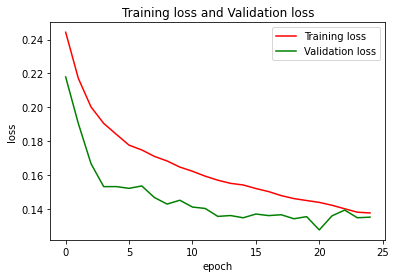

In [ ]:
#画出损失函数图
plt.plot(pic[0], 'r', label = 'Training loss', )
plt.plot(pic[1], 'g', label = 'Validation loss' )
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training loss and Validation loss')
plt.show()

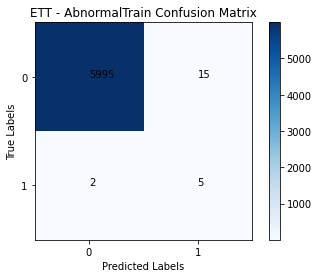

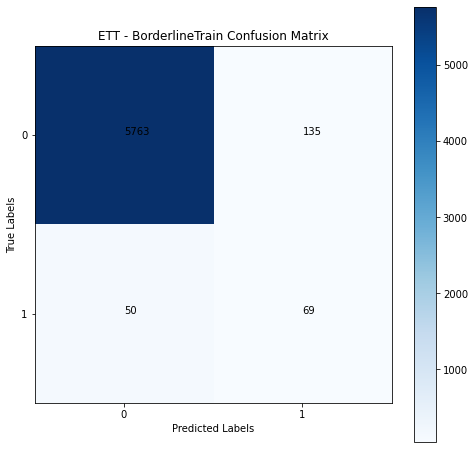

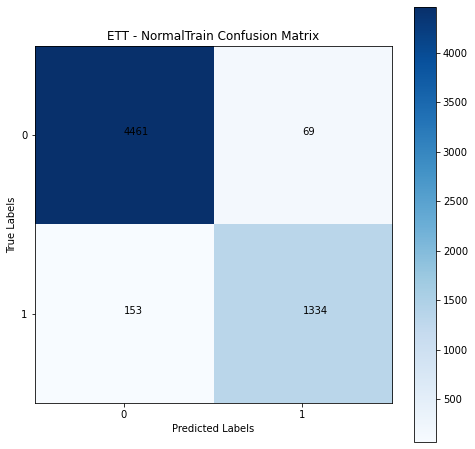

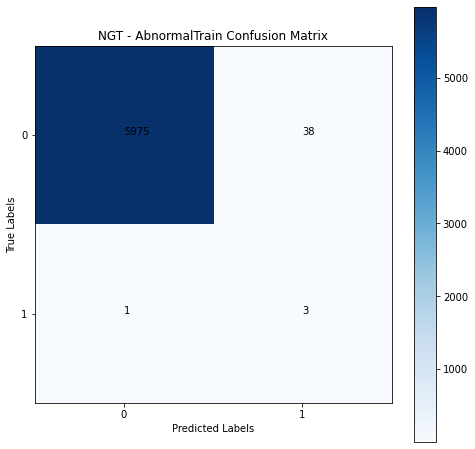

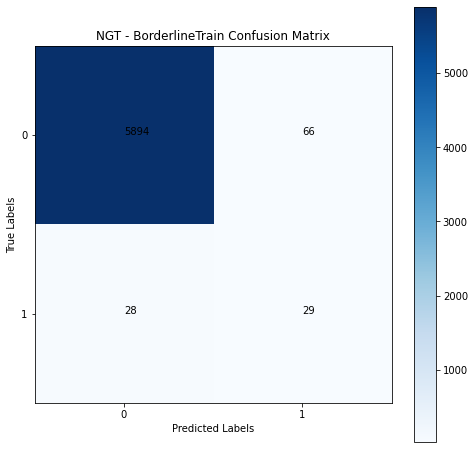

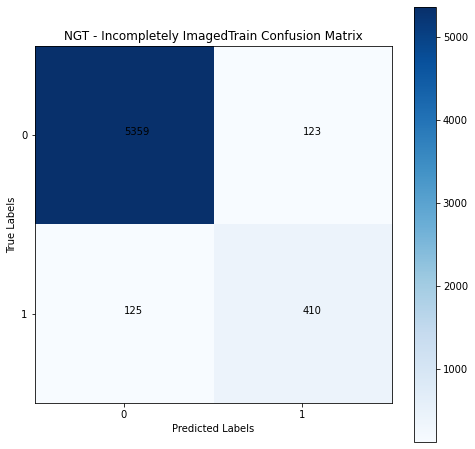

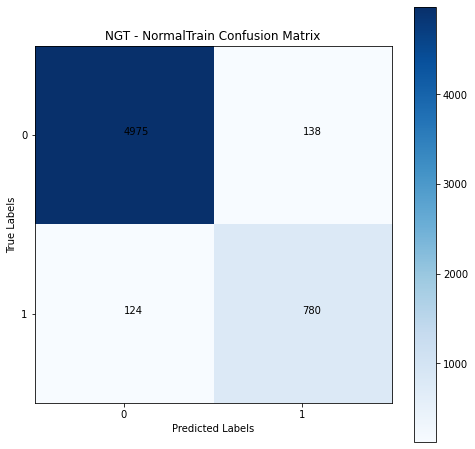

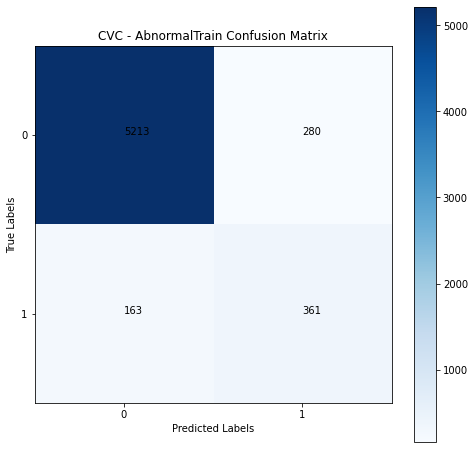

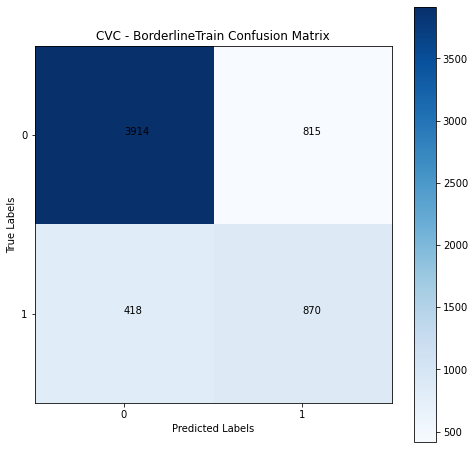

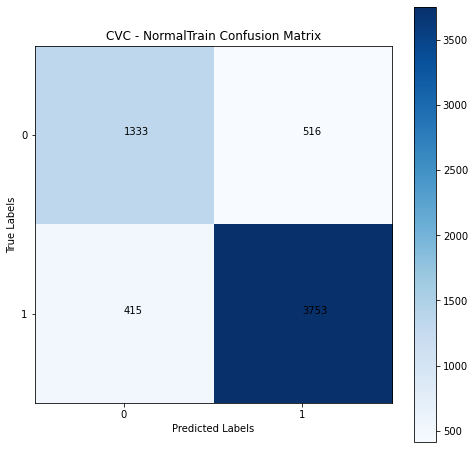

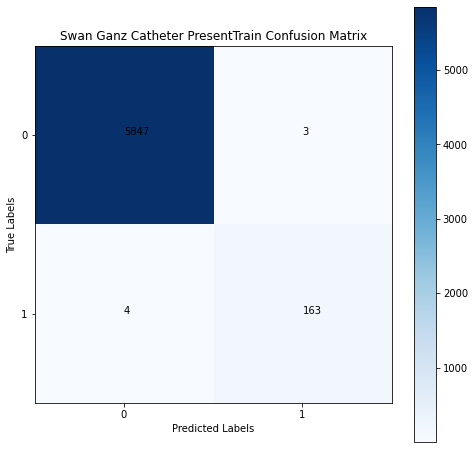

In [ ]:
for i in range(len(LABELS)):
    conf_matrix(l,p,i)

In [ ]:
#save the model
torch.save(model.state_dict(),'./model.pkl')
#load the model
#model = model.load_state_dict(torch.load('data/model.pkl'))